<span style="color:green; font-family:Georgia; font-size:2em;"> Curve fitting via Lmfit, Bayesian Optimization. </span>

<span style="color:Black; font-family:Georgia; font-size:1.55em;"> The goal is to find an alternate representation for the a sequence of states</span>

<span style="color:DarkSlateBlue; font-family:Georgia; font-size:1.5em;"> A fisful of loss functions. 
    </span>

The only disadvantage of l1-estimator is that arising optimization problem is hard, as the function is nondifferentiable everywhere, which is particularly troublesome for efficient nonlinear optimization. It means that we are better to stay with differentiable problems, but somehow incorporate robustness in estimation. To accomplish this we introduce a sublinear function $\rho(z)$ (i.e. its growth should be slower than linear) and formulate a new least-squares-like optimization problem:
\begin{equation}
\frac{1}{2} \sum_{i=1}^n \rho \left((\varphi(t_i; x) - y_i)^2 \right) \rightarrow \min_x
\end{equation}

The implemented choices of $\rho$ are the following:

1. Linear functior which gives a standard least squares: $\rho(z) = z$.
2. [Huber loss](https://en.wikipedia.org/wiki/Huber_loss): $\rho(z) = \begin{cases} 
z & z \leq 1 \\
\sqrt{z} - 1 & z > 1
\end{cases}$
3. Smooth approximation to absolute value loss, "soft l1 loss": $\rho(z) = 2 (\sqrt{1 + z} - 1)$
4. Cauchy loss: $\rho(z) = \ln(1 + z)$.
5. Loss by arctan: $\rho(z) = \arctan z$.


For reference see [this](https://scipy-cookbook.readthedocs.io/items/robust_regression.html) scipy cookbook

In [1]:
############################################################################
# The goal is to find an alternate representation for the above trajectory #
############################################################################


# This is a crude implementation
import os
import sys
import numpy as np
from scipy.optimize import curve_fit, leastsq
from lmfit import Model
import matplotlib.style
import matplotlib as mpl
mpl.style.use('ggplot')
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 200

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


import warnings
warnings.filterwarnings("ignore")

IMAGES_DIR = "/home/sherlock/optimal_learning/images/"


<span style="color:black; font-family:Georgia; font-size:2em;">A trajectory</span>

In [2]:
# Let's load in one optimal trajectory from one initial config


import pinocchio
import crocoddyl
import numpy as np



model = crocoddyl.ActionModelUnicycle()
model.timestep = 1e-4

T = 200
state= np.matrix([-2.5, 2.5, 1])
problem = crocoddyl.ShootingProblem(state.T, [ model ] * T, model)
ddp = crocoddyl.SolverDDP(problem)
done = ddp.solve()

A = np.squeeze(np.asarray(ddp.xs))
B = np.squeeze(np.asarray(ddp.us))

x = A[:,0]
y = A[:,1]
theta = A[:,2]
velocity,torque = B[:,0], B[:,1]


<span style="color:DarkSlateBlue; font-family:Georgia; font-size:1.5em;"> 1. A basic implementation. 
    </span>
    
<span style="color:Grey; font-family:Georgia; font-size:1.25em;">Goal : Represent a trajaectory is different ways. 
    </span>    

#### 1.1 Linear Regression

array([-0.75521131,  0.00554456])

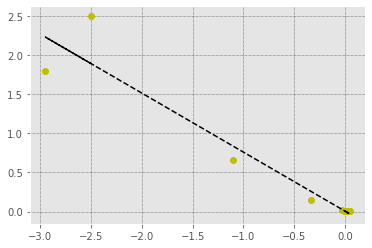

In [3]:

coef = np.polyfit(x, y, 1)
poly1d_fn = np.poly1d(coef) 

plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k')
plt.savefig(IMAGES_DIR + "numpy_regression.png")
poly1d_fn.coefficients

#### 1.2   Least Squares fit using a Gaussian Model

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 277
    # data points      = 201
    # variables        = 3
    chi-square         = 0.02277560
    reduced chi-square = 1.1503e-04
    Akaike info crit   = -1820.15945
    Bayesian info crit = -1810.24953
[[Variables]]
    amp:  4.65190550 +/- 0.02011595 (0.43%) (init = 5)
    cen: -2.32473111 +/- 0.00519425 (0.22%) (init = 5)
    wid:  0.71203250 +/- 0.00336474 (0.47%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(cen, wid) = -0.506
    C(amp, wid) =  0.318
    C(amp, cen) =  0.295


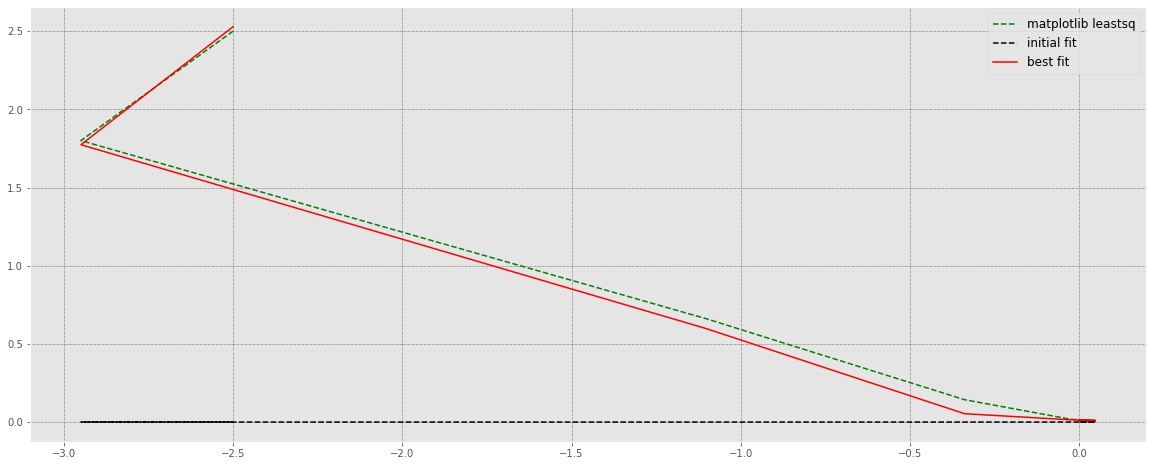

In [4]:
def gaussian(x, amp, cen, wid):
    """1-d gaussian: gaussian(x, amp, cen, wid)"""
    return (amp / (np.sqrt(2*np.pi) * wid)) * np.exp(-(x-cen)**2 / (2*wid**2))


gmodel = Model(gaussian)
# Uses Least Squares
result = gmodel.fit(y, x=x, amp=5, cen=5, wid=1)
print(result.fit_report())

plt.figure(figsize=(20,8))
plt.plot(x, y, 'g--', label = "matplotlib leastsq")
plt.plot(x, result.init_fit, 'k--', label='initial fit')
plt.plot(x, result.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.savefig(IMAGES_DIR + "gaussian_representation.png")
plt.show()

#### 1.3   Ridge fit using a polynomial model


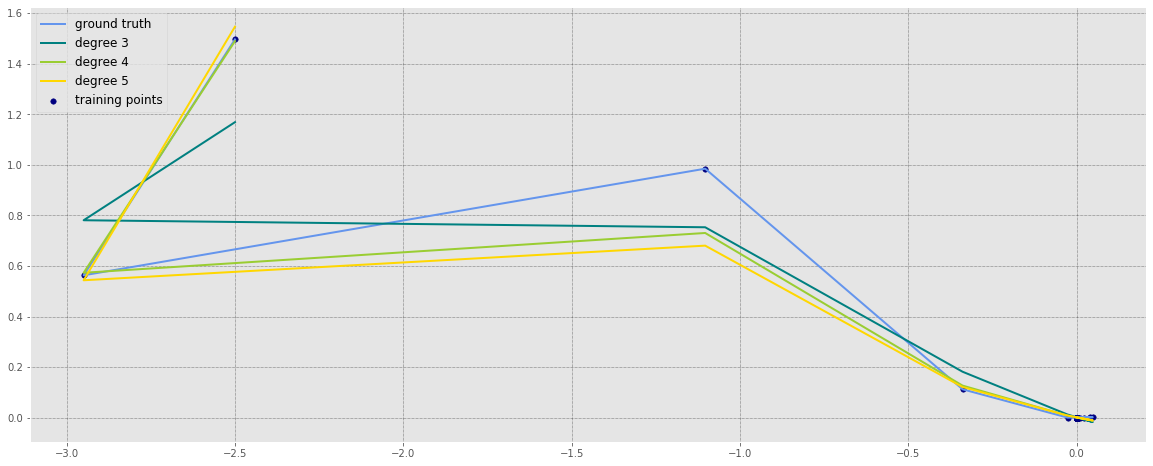

In [9]:

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
plt.figure(figsize=(20,8))

def f(x):
    """ function to approximate by polynomial interpolation"""
    return x * np.sin(x)
y = f(x)
x_plot = x
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]
colors = ['teal', 'yellowgreen', 'gold']
lw = 2
plt.plot(x_plot, f(x_plot), color='cornflowerblue', linewidth=lw,
         label="ground truth")
plt.scatter(x, y, color='navy', s=30, marker='o', label="training points")

for count, degree in enumerate([3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(X, y)
    y_plot = model.predict(X_plot)

    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)
plt.legend(loc='upper left')
plt.savefig(IMAGES_DIR + "sklearn_polynomial_features.png")
plt.show()

#### 1.4 Fitting using a decay model

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
N    2.398e-15     -inf      inf 8.937e-12     True     None     None
tau      0.05     -inf      inf 5.407e-08     True     None     None


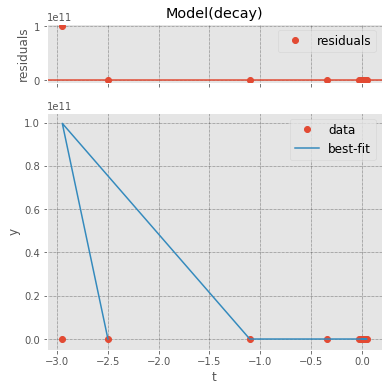

In [6]:
def decay(t, N, tau):
    return N*np.exp(-t/tau)

model = Model(decay, independent_vars=['t'])
result = model.fit(data = y, t=x, N= 7, tau= 0.05)
result.plot()
result.params.pretty_print()
plt.savefig(IMAGES_DIR + "decay_model.png")



#### 1.5 Fitting using emcee

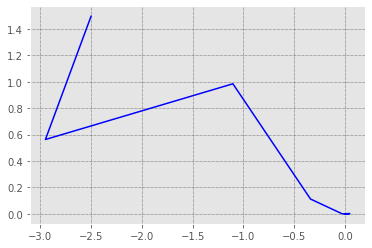

[[Variables]]
    a1:  1.4237e+08 (init = 4)
    a2: -1.4237e+08 (init = 4)
    t1:  39427042.7 (init = 3)
    t2:  44335983.8 (init = 3)


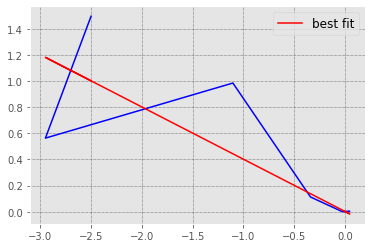

100%|██████████| 1000/1000 [00:10<00:00, 95.65it/s]


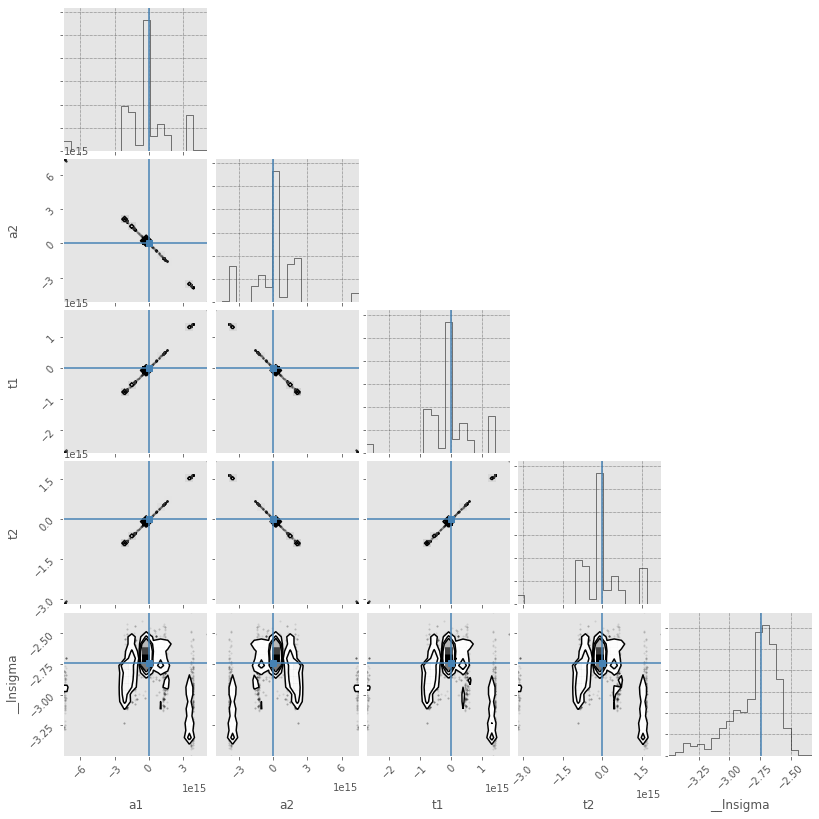


median of posterior probability distribution
--------------------------------------------
[[Variables]]
    a1:         2.0540e+08 +/- 1.6215e+15 (789466046.28%) (init = 1.423671e+08)
    a2:        -2.0540e+08 +/- 1.6215e+15 (789466047.15%) (init = -1.423671e+08)
    t1:         69434957.2 +/- 5.9324e+14 (854387133.12%) (init = 3.942704e+07)
    t2:         87773179.2 +/- 6.9445e+14 (791188441.94%) (init = 4.433598e+07)
    __lnsigma: -2.74354071 +/- 0.17759793 (6.47%) (init = -2.302585)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1, a2)        = -1.000
    C(t1, t2)        =  1.000
    C(a2, t2)        = -1.000
    C(a1, t2)        =  1.000
    C(a2, t1)        = -1.000
    C(a1, t1)        =  1.000
    C(t2, __lnsigma) = -0.174
    C(t1, __lnsigma) = -0.174
    C(a2, __lnsigma) =  0.174
    C(a1, __lnsigma) = -0.174

Maximum likelihood Estimation
-----------------------------
<Parameter 'a1', 3666781557007904.0, bounds=[-inf:inf]>
<Parameter 'a2', -366678155700790

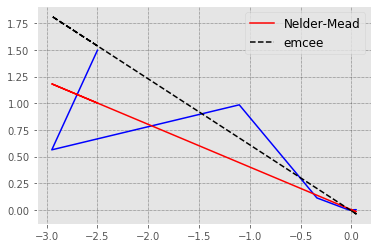

1 sigma spread 593385586465360.5
2 sigma spread 2038260243931963.5


In [7]:


import lmfit

try:
    import matplotlib.pyplot as plt
    HASPYLAB = True
except ImportError:
    HASPYLAB = False

try:
    import corner
    HASCORNER = True
except ImportError:
    HASCORNER = False

np.random.seed(0)

if HASPYLAB:
    plt.plot(x, y, 'b')
    plt.show()

p = lmfit.Parameters()
p.add_many(('a1', 4), ('a2', 4), ('t1', 3), ('t2', 3., True))


def residual(p):
    v = p.valuesdict()
    return v['a1']*np.exp(-x/v['t1']) + v['a2']*np.exp(-(x-0.1) / v['t2']) - y


mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')
lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
if HASPYLAB:
    plt.figure()
    plt.plot(x, y, 'b')
    plt.plot(x, residual(mi.params) + y, 'r', label='best fit')
    plt.legend(loc='best')
    plt.savefig(IMAGES_DIR + "fitting_with_emcee.png")
    plt.show()

# Place bounds on the ln(sigma) parameter that emcee will automatically add
# to estimate the true uncertainty in the data since is_weighted=False
mi.params.add('__lnsigma', value=np.log(0.1), min=np.log(0.001), max=np.log(2))

res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=300,
                     steps=1000, thin=20, params=mi.params, is_weighted=False)

if HASPYLAB and HASCORNER:
    emcee_corner = corner.corner(res.flatchain, labels=res.var_names,
                                 truths=list(res.params.valuesdict().values()))
    plt.show()

print("\nmedian of posterior probability distribution")
print('--------------------------------------------')
lmfit.report_fit(res.params)

# find the maximum likelihood solution
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]
for i, par in enumerate(p):
    p[par].value = mle_soln[i]
print("\nMaximum likelihood Estimation")
print('-----------------------------')
for _, vals in p.items():
    print(vals)

if HASPYLAB:
    plt.figure()
    plt.plot(x, y, 'b')
    plt.plot(x, residual(mi.params) + y, 'r', label='Nelder-Mead')
    plt.plot(x, residual(res.params) + y, 'k--', label='emcee')
    plt.legend()
    plt.savefig(IMAGES_DIR + "Nelder_Mead.png")
    plt.show()

quantiles = np.percentile(res.flatchain['t1'], [2.28, 15.9, 50, 84.2, 97.7])
print("1 sigma spread", 0.5 * (quantiles[3] - quantiles[1]))
print("2 sigma spread", 0.5 * (quantiles[4] - quantiles[0]))

#### 1.6 Fitting using bayesian Optimization

num acquisition: 1, time elapsed: 0.40s
num acquisition: 2, time elapsed: 3.01s
num acquisition: 3, time elapsed: 4.42s
num acquisition: 4, time elapsed: 5.65s
num acquisition: 5, time elapsed: 6.66s
num acquisition: 6, time elapsed: 7.70s
num acquisition: 7, time elapsed: 8.67s
num acquisition: 8, time elapsed: 9.78s
num acquisition: 9, time elapsed: 11.60s
num acquisition: 10, time elapsed: 12.64s
num acquisition: 11, time elapsed: 15.59s
num acquisition: 12, time elapsed: 16.66s
num acquisition: 13, time elapsed: 17.92s
num acquisition: 14, time elapsed: 20.47s
num acquisition: 15, time elapsed: 21.60s
num acquisition: 16, time elapsed: 23.42s
num acquisition: 17, time elapsed: 24.76s
num acquisition: 18, time elapsed: 25.97s
num acquisition: 19, time elapsed: 27.15s
num acquisition: 20, time elapsed: 28.88s
num acquisition: 21, time elapsed: 31.90s
num acquisition: 22, time elapsed: 34.47s
num acquisition: 23, time elapsed: 36.16s
num acquisition: 24, time elapsed: 39.42s
num acqui

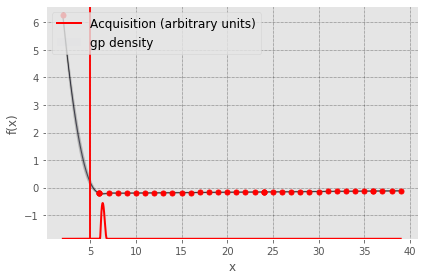

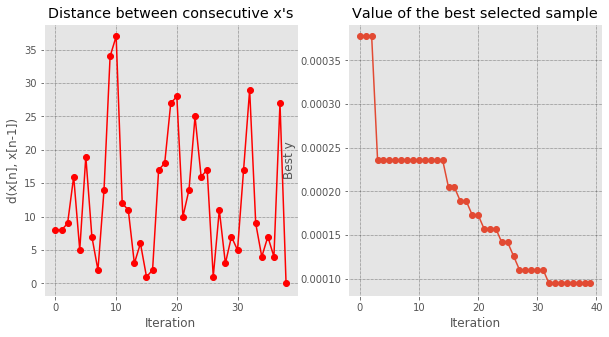

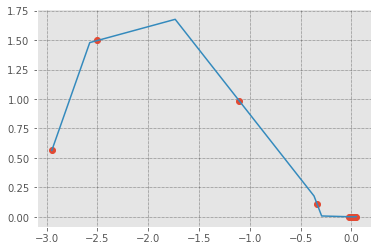

In [8]:
# Running an optimization to find the best number of line segments

import numpy as np
import matplotlib.pyplot as plt
import pwlf
from GPyOpt.methods import BayesianOptimization


# initialize piecewise linear fit with x and y positions
my_pwlf = pwlf.PiecewiseLinFit(x, y)

# Define the cost function
def my_obj(x):
    # define some penalty parameter l
    # it depends upon the noise in your data,
    # and the value of your sum of square of residuals
    l = y.mean()*0.001
    f = np.zeros(x.shape[0])
    for i, j in enumerate(x):
        my_pwlf.fit(j[0])
        f[i] = my_pwlf.ssr + (l*j[0])
    return f


# define the lower and upper bound for the number of line segements
bounds = [{'name': 'var_1', 'type': 'discrete', 'domain': np.arange(2, 40)}]

np.random.seed(12121)

myBopt = BayesianOptimization(my_obj, domain=bounds, model_type='GP',
                              initial_design_numdata=10,
                              initial_design_type='latin',
                              exact_feval=True, verbosity=True,
                              verbosity_model=False)
max_iter = 30

# perform the bayesian optimization to find the optimum number of line segments
myBopt.run_optimization(max_iter=max_iter, verbosity=True)

print('\n \n Opt found \n')
print('Optimum number of line segments:', myBopt.x_opt)
print('Function value:', myBopt.fx_opt)
myBopt.plot_acquisition()
myBopt.plot_convergence()

# perform the fit for the optimum
my_pwlf.fit(myBopt.x_opt)
# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)

# plot the results
plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.show()